In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

2025-06-28 18:46:05.345896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751136365.763757      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751136365.886300      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [4]:
ANNOTATION_PATH = '/kaggle/input/face-mask-detection/annotations'
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH)]

data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df['label'].value_counts()

label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

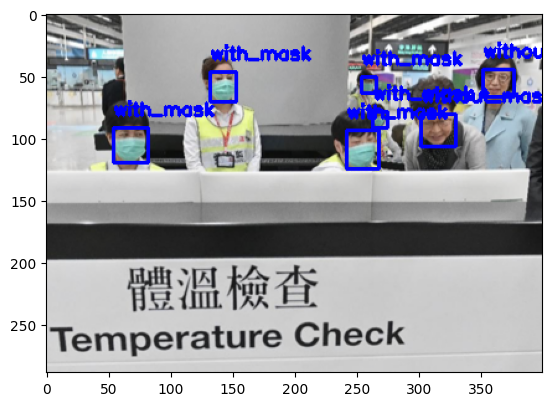

In [69]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation('/kaggle/input/face-mask-detection/images/maksssksksss119.png', parse_xml('/kaggle/input/face-mask-detection/annotations/maksssksksss119.xml'))

In [6]:
IMAGE_PATH = '/kaggle/input/face-mask-detection/images/'
label_pair = 
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

face_images = []
face_labels = []

for i in range(len(df)):
    row = df.iloc[i]
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    face_images.append(image)
    face_labels.append(label_pair[row['label']])

face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [53]:
from sklearn.utils import shuffle
face_images, face_labels = shuffle(face_images, face_labels, random_state=42)


In [54]:
train_x, val_x, train_y, val_y = train_test_split(
    face_images,
    face_labels,
    test_size=0.2,
    stratify=face_labels,
    random_state=42
)

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentation = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=25,
    fill_mode='nearest'
)


In [56]:
train_gen = augmentation.flow(train_x, train_y, batch_size=16)

val_x = preprocess_input(val_x)  



In [28]:
pip install -q git+https://github.com/qubvel/classification_models.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [57]:
from classification_models.tfkeras import Classifiers
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model

# Load ResNet-18 base with imagenet weights
ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
base_model.trainable = True  # for fine-tuning

# Add your classification head
x = Flatten()(base_model.output)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.2)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dense(3, activation='softmax')(x) 

# Build the model
model = Model(inputs=base_model.input, outputs=x)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [58]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [59]:
history = model.fit(
    train_gen,
    validation_data=(val_x, val_y),
    epochs=20
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 66s 210ms/step - accuracy: 0.7554 - loss: 6.1792 - val_accuracy: 0.1755 - val_loss: 3.0591
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.9035 - loss: 0.4446 - val_accuracy: 0.7939 - val_loss: 0.9892
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.9014 - loss: 0.3204 - val_accuracy: 0.8147 - val_loss: 0.4299
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.9243 - loss: 0.2526 - val_accuracy: 0.9190 - val_loss: 0.2693
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.9358 - loss: 0.2011 - val_accuracy: 0.9239 - val_loss: 0.2412
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.9353 - loss: 0.2294 - val_accuracy: 0.9411 - val_loss: 0.2143
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.9414 - loss: 0.1972 - val_accuracy: 0.9472 - val_loss: 0.1700
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 161ms/step - accuracy: 0.9436 - loss: 0

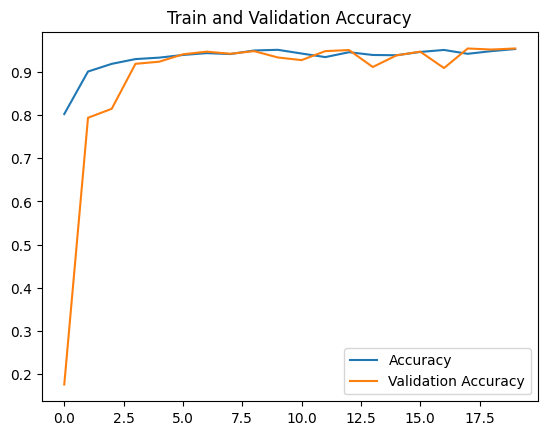

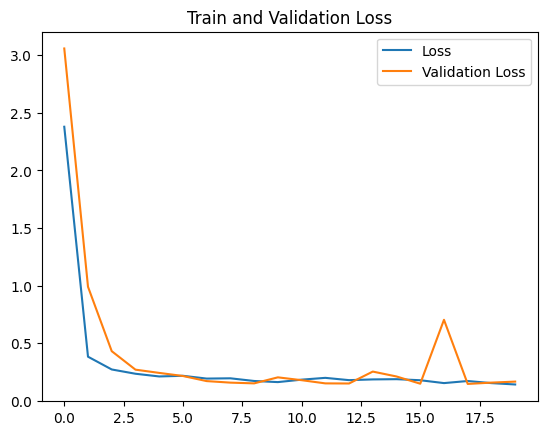

In [60]:
plt.figure()
plt.title('Train and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Validation Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [61]:
model.save('mask_model.h5')

In [63]:
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt -O /kaggle/working/deploy.prototxt
!wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel -O /kaggle/working/res10_300x300_ssd_iter_140000.caffemodel


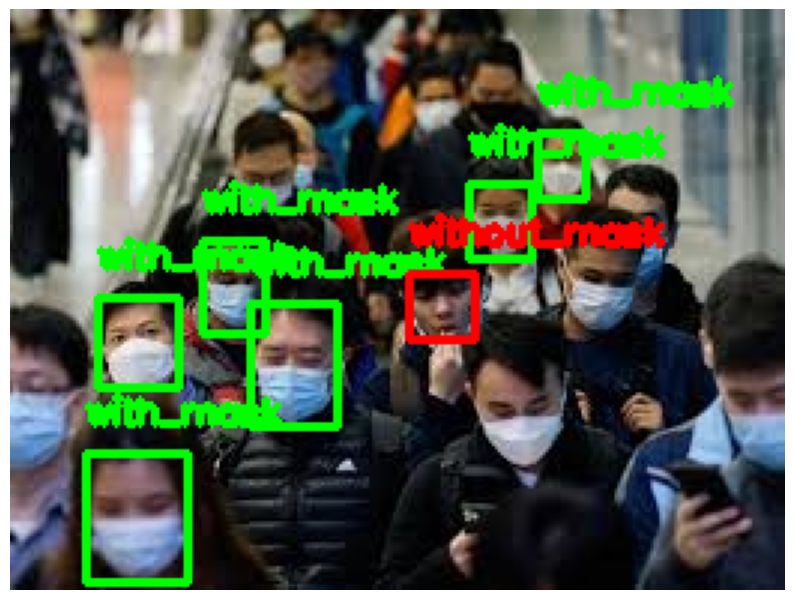

In [70]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Load OpenCV face detection model
face_net = cv2.dnn.readNetFromCaffe(
    '/kaggle/working/deploy.prototxt',
    '/kaggle/working/res10_300x300_ssd_iter_140000.caffemodel'
)

# Load your trained mask classification model
model = tf.keras.models.load_model('/kaggle/working/mask_model.h5')
# Class labels
label_map = {
    0: 'with_mask',
    1: 'without_mask',
    2: 'mask_weared_incorrect'
}


colors = {
    'with_mask': (0, 255, 0),         # Green
    'without_mask': (0, 0, 255),      # Red
    'mask_weared_incorrect': (0, 255, 255)  # Yellow
}

def predict_on_multi_face_image(img_path):
    image = cv2.imread(img_path)
    orig = image.copy()
    (h, w) = image.shape[:2]

    # Face detection using DNN
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.4:  # confidence threshold
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            face = image[startY:endY, startX:endX]
            if face.shape[0] == 0 or face.shape[1] == 0:
                continue

            # Preprocess for model
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = tf.expand_dims(face, axis=0)
            face = tf.keras.applications.densenet.preprocess_input(face) 

            # Predict
            pred = model.predict(face, verbose=0)
            label_index = np.argmax(pred[0])
            label = label_map[label_index]

            # Draw
            color = colors[label]
            cv2.rectangle(orig, (startX, startY), (endX, endY), color, 2)
            cv2.putText(orig, label, (startX, startY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 2)

    # Show
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


predict_on_multi_face_image('/kaggle/input/test43/images (1).jpeg')
